In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from ml_utils import (
    normalize_headers,
    preprocess_like_notebook,
    encode_and_build_xy,
    train_random_forest
)

# CSV path
DATA_PATH = "../Delivery predictions/Train.csv"

df_raw = pd.read_csv(DATA_PATH)

# Normalize common header variants to your expected names
df_raw = normalize_headers(df_raw)

# Quick peek
display(df_raw.head())
print(df_raw.shape)


,ID,Warehouse_block,Shipment_mode,Customer_care_calls,Customer_rating,Product_Cost,Prior_purchases,Product_importance,Gender,Discount_offered,Weight_in_gms,Reached_on_time
0,1,D,Flight,4,2,177,3,low,F,44,1233,1
1,2,F,Flight,4,5,216,2,low,M,59,3088,1
2,3,A,Flight,2,2,183,4,low,M,48,3374,1
3,4,B,Flight,3,3,176,4,medium,M,10,1177,1
4,5,C,Flight,2,2,184,3,medium,F,46,2484,1


(10999, 12)


In [34]:
# Schema & missing values
display(df_raw.info())
display(df_raw.isna().sum())

# Class balance if the original target column is present in raw
if 'Reached_on_time' in df_raw.columns:
    cls_raw = df_raw['Reached_on_time'].value_counts(normalize=True) * 100
elif 'Reached.on.Time_Y.N' in df_raw.columns:
    cls_raw = df_raw['Reached.on.Time_Y.N'].value_counts(normalize=True) * 100
else:
    cls_raw = None

print("\nTarget class balance in raw data (%):")
display(cls_raw)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10999 entries, 0 to 10998
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   ID                   10999 non-null  int64 
 1   Warehouse_block      10999 non-null  object
 2   Shipment_mode        10999 non-null  object
 3   Customer_care_calls  10999 non-null  int64 
 4   Customer_rating      10999 non-null  int64 
 5   Product_Cost         10999 non-null  int64 
 6   Prior_purchases      10999 non-null  int64 
 7   Product_importance   10999 non-null  object
 8   Gender               10999 non-null  object
 9   Discount_offered     10999 non-null  int64 
 10  Weight_in_gms        10999 non-null  int64 
 11  Reached_on_time      10999 non-null  int64 
dtypes: int64(8), object(4)
memory usage: 1.0+ MB


None

ID                     0
Warehouse_block        0
Shipment_mode          0
Customer_care_calls    0
Customer_rating        0
Product_Cost           0
Prior_purchases        0
Product_importance     0
Gender                 0
Discount_offered       0
Weight_in_gms          0
Reached_on_time        0
dtype: int64


Target class balance in raw data (%):


Reached_on_time
1    59.669061
0    40.330939
Name: proportion, dtype: float64

In [35]:
df = preprocess_like_notebook(df_raw)

# After preprocessing we also have a friendly label
if 'DeliveryStatus' in df.columns:
    print("\nOn-Time vs Late after preprocessing (%):")
    display((df['DeliveryStatus'].value_counts(normalize=True) * 100).round(2))

display(df.head())
print(df.shape)


On-Time vs Late after preprocessing (%):


DeliveryStatus
Late       59.67
On Time    40.33
Name: proportion, dtype: float64

,Warehouse_block,Shipment_mode,Customer_care_calls,Customer_rating,Product_Cost,Prior_purchases,Product_importance,Discount_offered,Weight_in_gms,Reached_on_time,Estimated_Delivery_Time,Simulated_Distance_km,DeliveryStatus
0,D,Flight,4,2,177,3,low,44,1233,1,15.3165,420.0,Late
1,F,Flight,4,5,216,2,low,59,3088,1,19.5440,600.0,Late
2,A,Flight,2,2,183,4,low,48,3374,1,14.4870,90.0,Late
3,B,Flight,3,3,176,4,medium,10,1177,1,6.9885,180.0,Late
4,C,Flight,2,2,184,3,medium,46,2484,1,13.9420,300.0,Late


(10999, 13)


In [36]:
X, y, feature_cols = encode_and_build_xy(df)

print("X shape:", X.shape)
print("y shape:", y.shape)
print("First 5 feature columns:", feature_cols[:5])

X shape: (10999, 16)
y shape: (10999,)
First 5 feature columns: ['Customer_care_calls', 'Customer_rating', 'Product_Cost', 'Prior_purchases', 'Discount_offered']


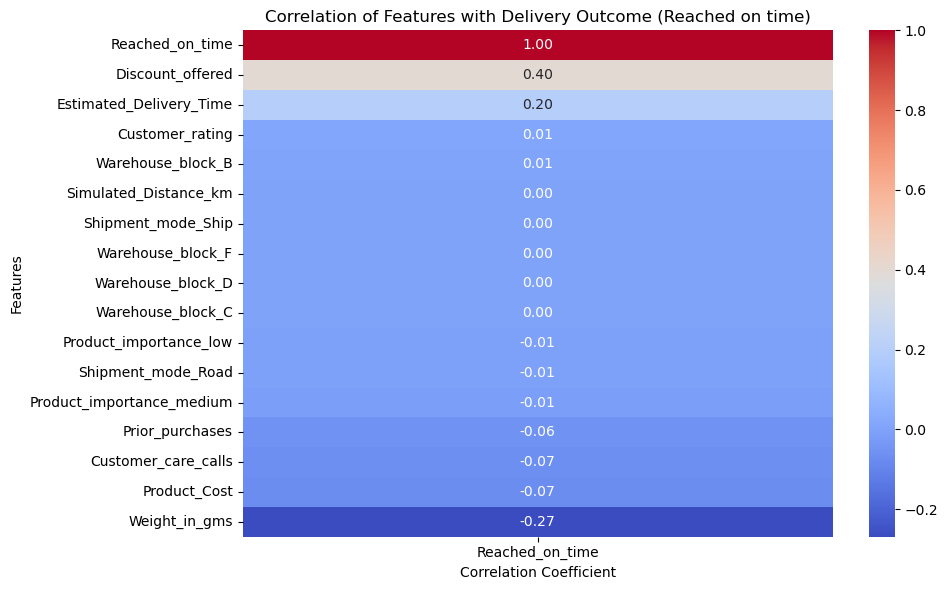

In [49]:
# Correlation matrix including the target
encoded = X.copy()
encoded['Reached_on_time'] = y.values

corr = encoded.corr()

plt.figure(figsize=(10, 6))
sns.heatmap(
    corr[['Reached_on_time']].sort_values(by='Reached_on_time', ascending=False),
    annot=True, cmap='coolwarm', fmt=".2f"
)
plt.title('Correlation of Features with Delivery Outcome (Reached on time)')
plt.ylabel('Features')
plt.xlabel('Correlation Coefficient')
plt.tight_layout()
plt.show()

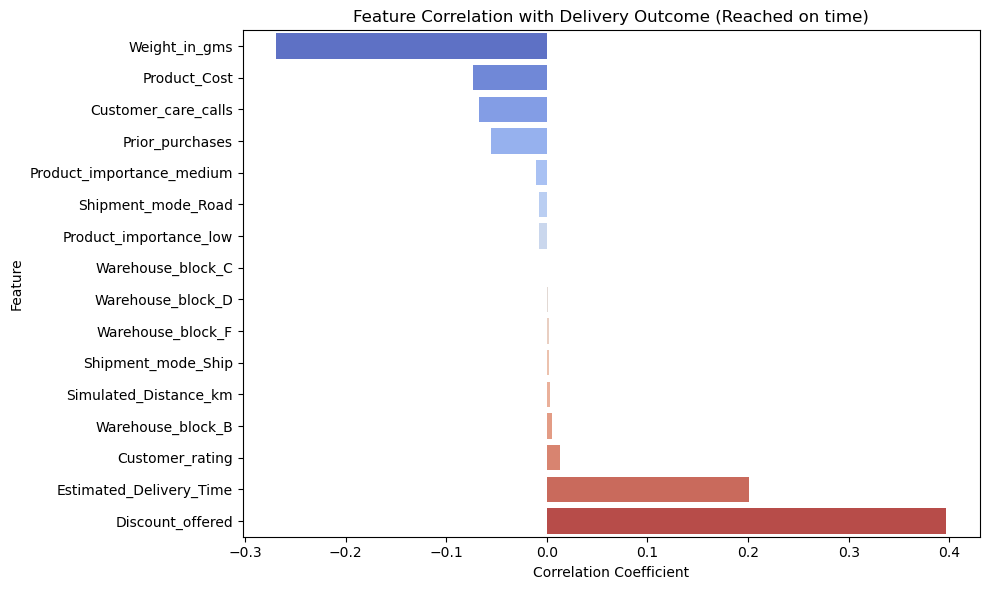

In [50]:
corr_target = corr['Reached_on_time'].drop('Reached_on_time')
corr_target_sorted = corr_target.sort_values(ascending=True)

plt.figure(figsize=(10, 6))
sns.barplot(x=corr_target_sorted.values, y=corr_target_sorted.index, palette='coolwarm')


plt.title('Feature Correlation with Delivery Outcome (Reached on time)')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

In [ ]:
rf, report, auc, cm, splits = train_random_forest(X, y)
X_train, X_test, y_train, y_test = splits

print("ROC AUC:", round(auc, 3))
print("\nClassification report (dict to DataFrame):")
display(pd.DataFrame(report).T)

ROC AUC: 0.75

Classification report (dict to DataFrame):


,precision,recall,f1-score,support
0,0.576887,0.691620,0.629065,895.000000
1,0.755102,0.652107,0.699836,1305.000000
accuracy,0.668182,0.668182,0.668182,0.668182
macro avg,0.665995,0.671864,0.664450,2200.000000
weighted avg,0.682601,0.668182,0.671045,2200.000000


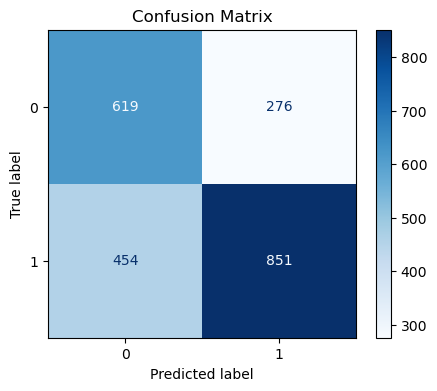

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

fig, ax = plt.subplots(figsize=(5, 4))
ConfusionMatrixDisplay.from_estimator(rf, X_test, y_test, cmap="Blues", ax=ax)
ax.set_title("Confusion Matrix")
plt.show()

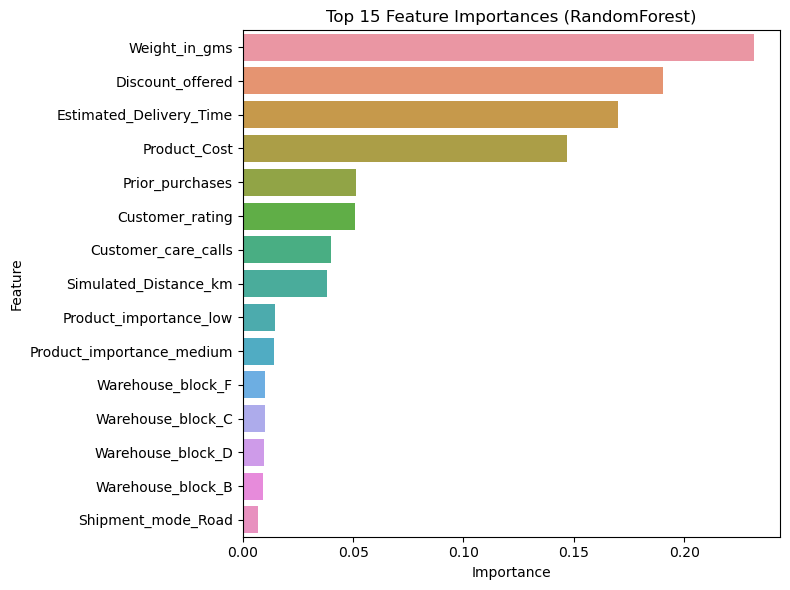

,Feature,Importance
5,Weight_in_gms,0.231817
4,Discount_offered,0.190284
6,Estimated_Delivery_Time,0.170026
2,Product_Cost,0.146903
3,Prior_purchases,0.051397
1,Customer_rating,0.050837
0,Customer_care_calls,0.039910
7,Simulated_Distance_km,0.038143
14,Product_importance_low,0.014585
15,Product_importance_medium,0.013970


In [ ]:
importances = pd.DataFrame({
    "Feature": X.columns,
    "Importance": rf.feature_importances_
}).sort_values("Importance", ascending=False)

plt.figure(figsize=(8, 6))
sns.barplot(x="Importance", y="Feature", data=importances.head(15))
plt.title("Top 15 Feature Importances (RandomForest)")
plt.tight_layout()
plt.show()

display(importances.head(30))